In [1]:
using CSV, DataFrames, Gadfly, Distributions, SparseArrays, LinearAlgebra

include("iGMRF.jl");
include("dataGen.jl");

# Création de la grille à 9 cellules

Chaque cellule est représentée par un triplet $[\mu, \sigma, \xi]$ indiquant les vraie valeur des paramètres de la GEV à déterminer.

In [2]:
# Seed
Random.seed!(400)
# Dimensions de la grille
m₁ = 3;
m₂ = 3;
# Nb total de cellules
m = m₁ * m₂
# Hyperparamètres
κᵤ = 100.0;
# Matrice de structure
F = iGMRF(m₁, m₂, κᵤ);
# Grille cible
grid_target = generateTargetGrid(F);
grid_target[:, :, 1] = grid_target[:, :, 1] .+ 10;

In [3]:
grid_target[:, :, 1]

3×3 Matrix{Float64}:
 10.0212  10.0154  9.88228
 10.0775  10.0098  9.94918
 10.0956   9.9755  9.97355

In [4]:
grid_target[:, :, 2]

3×3 Matrix{Float64}:
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

In [5]:
grid_target[:, :, 3]

3×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

# Génération de données

Le but est de générer des données sur chaque cellule à partir des paramètres de la GEV de la grille cible.

In [10]:
nobs = 100;
data = generateData(grid_target, nobs);

In [11]:
data

9-element Vector{Vector{Float64}}:
 [12.240682784141626, 9.621417291612469, 9.754494171763968, 12.271969563649202, 9.010088679836304, 10.37854664173395, 9.953170110473183, 9.445009003021907, 9.742009013625772, 9.570691209584776  …  10.518164573659204, 9.930013357326203, 10.282186137930879, 12.850825190676971, 11.539774471964721, 9.408520146607469, 10.911372616309231, 8.729801983142732, 8.72967686719628, 11.836572621374048]
 [11.273789202970812, 8.631556095806973, 13.163945842014405, 11.344148819126897, 9.546754812779685, 10.288636123061432, 8.323184365488917, 11.519918761572495, 10.633947875839283, 9.701374233994922  …  11.842867771041316, 10.125426468920546, 10.559271503126375, 11.915013128851271, 11.83414170304287, 10.090763718674232, 9.618733796527398, 11.037493453323496, 12.569207209872223, 10.34323657298342]
 [10.84714848560555, 10.09386643901673, 11.374159042999196, 10.054626371286963, 11.072357692987763, 9.28577559547066, 11.744733738776487, 9.621447951938798, 9.092795759344487,

# Modèle 

In [81]:
include("NUTS.jl");

niter = 1000;
θ₀ = vcat([50], fill(0, m))
F = iGMRF(m₁, m₂, 0)
nchains = 1;

θ = nuts(niter, θ₀, Y=data, F=F);
κᵤ = θ.value[:, 1, 1];
μ = θ[:, 2:end, 1];

warming_size = Int(0.2 * niter)

newθ = θ[warming_size:end, :, :];
κ̂ᵤ = mean(newθ.value[:, 1, 1]);
μ̂ = mean(newθ.value[:, 2:end, 1], dims=1);

In [82]:
changerate(newθ).value

11×1×1 Array{Float64, 3}:
[:, :, 1] =
 0.698
 0.698
 0.698
 0.698
 0.698
 0.698
 0.698
 0.698
 0.698
 0.698
 0.698

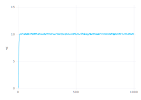

In [83]:
plot(y=μ.value[:, 1, 1], Geom.line)

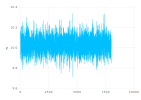

In [84]:
plot(y=newμ.value[:, 1, 1], Geom.line)

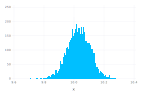

In [85]:
plot(x=newμ.value[:, 1, 1], Geom.histogram)

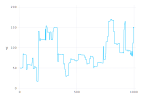

In [86]:
plot(y=κᵤ, Geom.line)

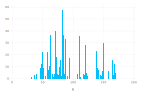

In [87]:
plot(x=κᵤ, Geom.histogram)

In [88]:
κ̂ᵤ

94.30675502141905

In [89]:
summarystats(newθ)

      Mean        SD        Naive SE       MCSE         ESS    
κᵤ 94.306755 35.062110576 1.2388587626 9.1597605368  14.6523698
μ1 10.026228  0.070325320 0.0024848230 0.0030162251 543.6206347
μ2 10.015709  0.062230221 0.0021987967 0.0029342871 449.7772318
μ3  9.971802  0.065861234 0.0023270923 0.0035118687 351.7087566
μ4 10.047527  0.062553051 0.0022102034 0.0039764637 247.4588215
μ5  9.992215  0.053625373 0.0018947594 0.0023237766 532.5395842
μ6  9.980436  0.061281091 0.0021652609 0.0028503621 462.2244504
μ7  9.983168  0.063062378 0.0022281996 0.0026980365 546.3174360
μ8  9.954647  0.059331938 0.0020963909 0.0039337658 227.4888244
μ9  9.969247  0.064182585 0.0022677801 0.0032488399 390.2813355



In [90]:
reshape(μ̂, m₁, m₂)'

3×3 adjoint(::Matrix{Float64}) with eltype Float64:
 10.0262   10.0157   9.9718
 10.0475    9.99222  9.98044
  9.98317   9.95465  9.96925

In [91]:
grid_target[:, :, 1]

3×3 Matrix{Float64}:
 10.0212  10.0154  9.88228
 10.0775  10.0098  9.94918
 10.0956   9.9755  9.97355

Distance entre les deux matrices

In [92]:
norm(reshape(μ̂, m₁, m₂)' .- grid_target[:, :, 1], 2) / m

0.01696645166262009

In [73]:
describe(newθ)

Iterations = 2000:10000
Thinning interval = 1
Chains = 1
Samples per chain = 8001

Empirical Posterior Estimates:
      Mean        SD         Naive SE        MCSE         ESS    
κᵤ 56.884525 33.012304320 0.36906571688 3.12365966354  111.692564
μ1 10.032897  0.074907961 0.00083744413 0.00092762874 6520.900305
μ2 10.023535  0.070443960 0.00078753820 0.00109865184 4111.188122
μ3  9.963475  0.075436476 0.00084335274 0.00127941664 3476.472528
μ4 10.067568  0.072461187 0.00081009007 0.00215516154 1130.449661
μ5  9.990481  0.065033205 0.00072704789 0.00076328962 7259.247395
μ6  9.979183  0.068925788 0.00077056557 0.00092507968 5551.434084
μ7  9.974459  0.075208160 0.00084080024 0.00106640036 4973.811898
μ8  9.941212  0.069998510 0.00078255823 0.00172139231 1653.552068
μ9  9.968584  0.074538902 0.00083331818 0.00086513150 7423.380754

Quantiles:
      2.5%      25.0%      50.0%     75.0%      97.5%   
κᵤ 12.518256 34.5871272 50.6827716 70.639585 149.1587501
μ1  9.888837  9.9827476 10.0327874